This notebook is for generating figures related to the case of McCabe-Glynn et al. (2013)

Load necessary packages

In [1]:
%matplotlib inline
import numpy as np
from numpy import genfromtxt
from lipd.start import *
from mpl_toolkits.basemap import Basemap
from scipy.stats.mstats import mquantiles
from scipy import interpolate
from scipy.interpolate import UnivariateSpline
from scipy.signal import butter, lfilter, filtfilt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from nitime import algorithms as alg 
from nitime import utils
from nitime.viz import winspect
from nitime.viz import plot_spectral_estimate
from scipy.stats import t
import xray
from rpy2.robjects import FloatVector
from rpy2.robjects.vectors import StrVector
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
r = robjects.r

Where are your files stored?
1. Current Directory
2. Browse Computer
3. Downloads folder
4. Notebooks folder

Option: 1
Networkx is not available. Some visualization tools might not work
 To download networkx: http://networkx.lanl.gov/


Load data (in LiPD format)

In [126]:
loadLipds()
f1 = getCsv("Crystal2013.lpd")
d18O = f1["Crystal2013.paleo1measurement1.csv"]["d18O_VPDB"]
d18O = np.asarray(d18O)
depth = f1["Crystal2013.paleo1measurement1.csv"]["Depth"]
depth = np.asarray(depth)
depth = depth /10.0 #depth in cm

Found: 1 LiPD file(s)
processing: Crystal2013.lpd
Process Complete
Process Complete


Load chronology information

In [127]:
age_c = f1["Crystal2013.chron1measurement1.csv"]["230Th Age (yr BP) (corrected)"]
age_c = np.asarray(age_c)
age_c = np.insert(age_c,0,-57) #insert the top age

depth_age = f1["Crystal2013.chron1measurement1.csv"]["Depth (mm)"]
depth_age = np.asarray(depth_age)
depth_age = np.insert(depth_age,0,0.05)

age_sd = f1["Crystal2013.chron1measurement1.csv"]["230Th Age_uncertaity (yr BP) (corrected)"]
age_sd = np.asarray(age_sd)
age_sd = np.insert(age_sd,0,0.1)

plot raw age model

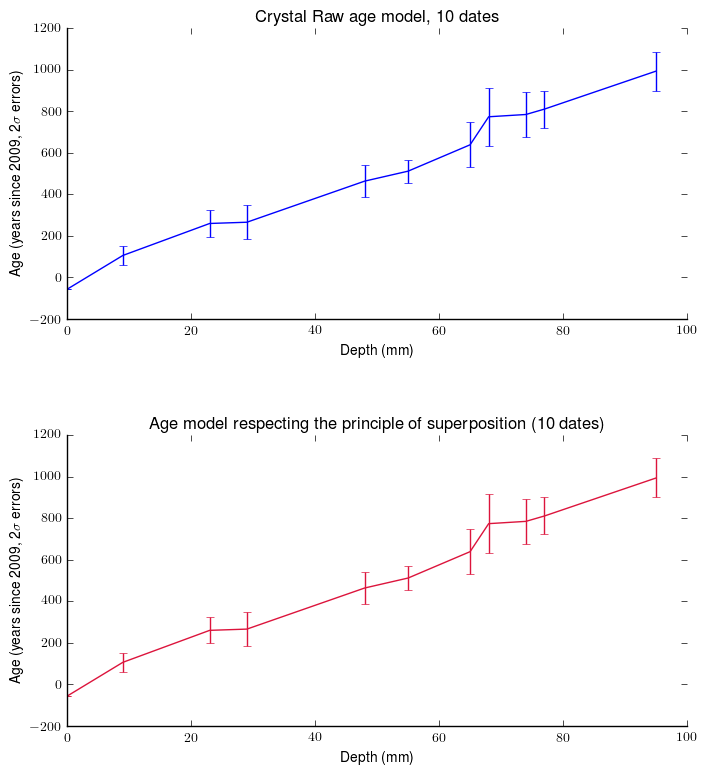

In [178]:
# plot age model
plt.rc('text', usetex=True,)
plt.rc('font', family='sans-serif')

# create figure
f, (ax1, ax2) = plt.subplots(2, 1)
f.set_figheight(9); f.set_figwidth(8)
ax1.spines["top"].set_visible(False)  
ax1.spines["right"].set_visible(False)  
ax1.errorbar(depth_age,age_c,age_sd)
ax1.set_xlabel(r'Depth (mm)')
ax1.set_ylabel(r'Age (years since 2009, 2$\sigma$ errors)')
ax1.set_title(r'Crystal Raw age model, 10 dates')
plt.subplots_adjust(hspace = 0.4)
ax2.spines["top"].set_visible(False)  
ax2.spines["right"].set_visible(False)  
ax2.errorbar(depth_age,age_c,age_sd,color='Crimson')
ax2.set_xlabel(r'Depth (mm)')
ax2.set_ylabel(r'Age (years since 2009, 2$\sigma$ errors)')
ax2.set_title(r'Age model respecting the principle of superposition (10 dates)')

Preparation for the age modelling 

In [129]:
# convert to ages BP
year_BP = age_c
year_CE = 1950 - year_BP
top_date = 2007
year_top = year_BP + top_date - 1950

nyears = int(year_CE.max()-year_CE.min())+1
positions = FloatVector(depth_age/10.0)# position in core in cm
ages = FloatVector(year_BP)# age estimate
ages_CE = FloatVector(year_top)# age estimate
sd  = FloatVector(age_sd/2)# SD of ages
nd  = age_c.shape[0] # number of dates
calCurves = StrVector(['normal' for i in range(nd)] )
#predictPositions = r.seq(0,d.max(),by=d.max()/nyears) 
predictPositions = FloatVector(depth)
# Specify extractDate (top-most age of the core, in years BP)
topDate= 1950 - top_date
#topDate = 0

Generate different age-depth realizations by using Bchron age model

In [130]:
Bchron=importr('Bchron')
haha = Bchron.Bchronology(ages=ages, ageSds=sd, positions=positions, iterations=10000, burn=2000, thin=8, extractDate=topDate, calCurves=calCurves, predictPositions=predictPositions)

  |                                                                  
  |                                                            |   0%
  |                                                                  
  |                                                            |   1%
  |                                                                  
  |=                                                           |   1%
  |                                                                  
  |=                                                           |   2%
  |                                                                  
  |==                                                          |   3%
  |                                                                  
  |==                                                          |   4%
  |                                                                  
  |===                                                         |   4%
  |                 

Retrieve the result of estimated ages

In [131]:
# The variable 'theta' is the posterior estimated values of the ages, and is stored as
# the first matrix of the List Vector class 'ages'

theta = haha[0]
theta=np.array(theta)

thetaPredict = haha[4]
thetaPredict=np.array(thetaPredict)

# Save depth horizons
depths=np.array(predictPositions)
depth_horizons=depths[:-1]

# save all the chronologies as independent time axes and plot original data with
# varying X values.

thetaPredict.shape
chrons=thetaPredict[:,:-1]      # reshape to be same size as input data

# Call BCHRON observation model to return CHRONS (in years BP)
# NOTE" Bchron will FREAK OUT unless ages increase with depth (no reversals)
chronBP = chrons

# recast in years CE
chronCE = np.flipud(1950 - chronBP).transpose()
chronQ  = mquantiles(chronCE, prob=[0.025, 0.5, 0.975], axis=1)
nchrons = chronCE.shape[1]

(1000, 1053)

Plot the age model

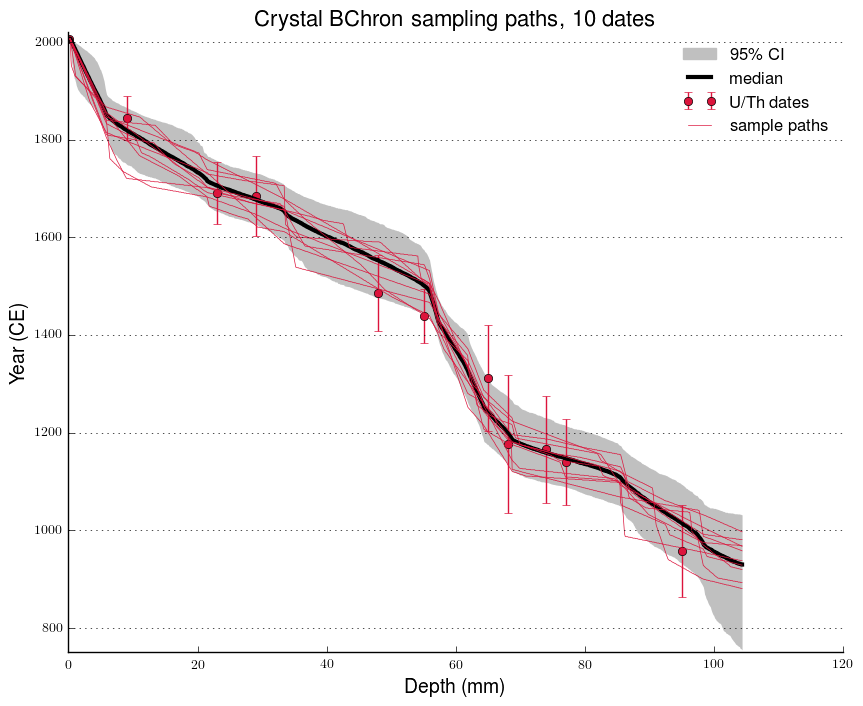

In [133]:
# PLOT IT OUT
x = depth_horizons*10
f2 = plt.figure(figsize=(10,8))
ax = plt.axes()
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.fill_between(x, chronQ[:,0], chronQ[:,2], facecolor='Silver',edgecolor='Silver',lw=0.0)  # see http://stackoverflow.com/questions/14143092/why-does-matplotlib-fill-between-draw-edgelines-only-on-a-pdf
CI = mpatches.Patch(color='silver') # create proxy artist for labeling
lbl = ('95\% CI','median','U/Th dates','sample paths')
dat = plt.errorbar(depth_age,year_CE,age_sd,color='Crimson',fmt='o')
med, = plt.plot(x,chronQ[:,1],color = 'black', lw=3.0)  # that comma is really important !! wouldn't work without it

# plot a few random paths
nl = 10
idx = np.random.randint(nchrons+1, size=nl)
l = plt.plot(x,chronCE[:,idx],lw=0.5,color = 'Crimson')

#col = plt.cm.YlGn(np.arange(nl))
#for i in range(nl):
#    plt.plot(x,chronCE[:,idx[i]],lw=1,color=col[i,:])
#    plt.draw()
# I do not understand why line colors do not get updated. this is most irritating

lg = plt.legend((CI,med,dat,l[1]),lbl,loc='upper right'); lg.draw_frame(False)
plt.grid(axis='y'); plt.ylim(750,2020);  plt.xlim(0,120)
plt.xlabel(r'Depth (mm)',fontsize=14); plt.ylabel(r'Year (CE)',fontsize=14); 
plt.title(r'Crystal BChron sampling paths, 10 dates',fontsize=16)

#f2.savefig('Crystal_BChron.pdf', dpi=400, facecolor='w', edgecolor='w',transparent=True)

# save to file
np.savez('Crystal_Bchron.npz',chronCE=chronCE,depth_horizons=depth_horizons)

plot timeseries quantiles

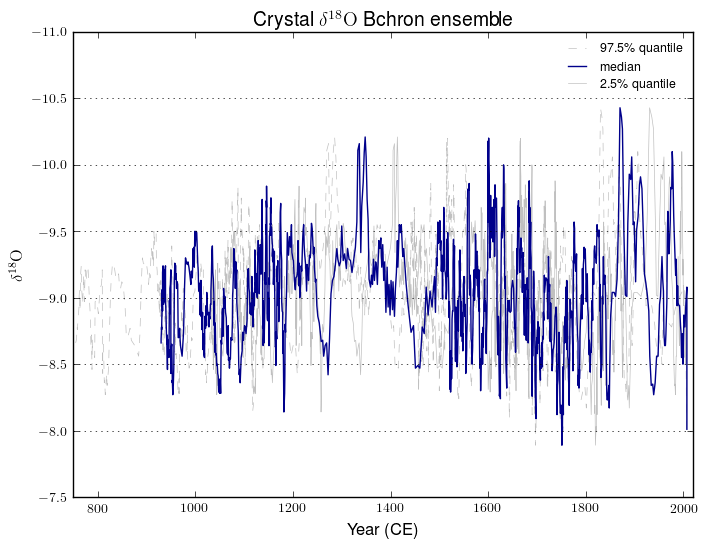

In [141]:
f, ax = plt.subplots(1, 1)
f.set_figheight(6); f.set_figwidth(8)
chronQ  = mquantiles(chronCE, prob=[0.025, 0.5, 0.975], axis=1)
Xr = d18O[:-1]
hp,= plt.plot(chronQ[:,0], Xr, lw=0.5, color='silver',ls='dashed')
hl,= plt.plot(chronQ[:,2], Xr, lw=0.5, color='silver')
hm,= plt.plot(chronQ[:,1], Xr, lw=1.0, color='DarkBlue')
plt.xlim(750,2020); plt.ylim(-7.5,-11); plt.grid(axis='y')
lbl = ('97.5\% quantile','median','2.5\% quantile')
lg = plt.legend((hp,hm,hl),lbl,loc='upper right',fontsize=9); lg.draw_frame(False)
# label axes
plt.ylabel(r'$\delta^{18}\mathrm{O}$',fontsize=12)
plt.xlabel(r'Year (CE)',fontsize=12)
plt.title(r'Crystal $\delta^{18}\mathrm{O}$ Bchron ensemble',fontsize=14)
#f.savefig('Crystal_ts.pdf', dpi=400, facecolor='w', edgecolor='w',transparent=True)

Now we are going to correlate speleothem $\delta^{18}O$ with sea surface temperature

First read monthly sea surface temperature from a netCDF file

In [12]:
#read Kaplan SST
nc = xray.open_dataset('/Users/hujun/Downloads/sst.mon.anom.nc')
lat0 = nc['lat']
lon0 = nc['lon']
sst = nc['sst']
nlat=lat0.shape[0]
nlon=lon0.shape[0]
sst_ann=sst[19:1831:12,:,:]

Prepare functions for filtering

In [144]:
def butter_lowpass(cutoff, fs, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def filter(x, cutoff, axis, fs=1.0, order=3):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, x, axis=axis)
    return y

Get the annual mean SST from 1857-2007

In [145]:
#annual mean
for i in range(sst_ann.shape[0]):
    sst_ann[i,:,:]=np.mean(sst[i*12+19:(i+1)*12+19,:,:],axis=0)

#sst_ann_fil=filter(sst_ann,1.0/30,0)
sst_ann_fil=sst_ann

Read age model results

In [146]:
crys = np.load('Crystal_Bchron.npz')
chronCE = crys['chronCE']
depth = crys['depth_horizons']
chronQ  = mquantiles(chronCE, prob=[0.025, 0.5, 0.975], axis=1)

Prepare the function for deleting repeated calendar year in the age model result

In [147]:
def coarse_grain(t,X):
    tu = np.unique(t) # find unique values
    nu = tu.shape[0]
    Xu = np.zeros(nu,)
    for j in range(nu):
        Xu[j] = np.mean(X[np.where(t==tu[j])])
    return (tu,Xu)

Interpolate $\delta^{18}O$ on the annual scale

In [148]:
#interpolation
d18O_multi=np.zeros((chronCE.shape[1],sst_ann_fil.shape[0]))
sst_corr=np.zeros((chronCE.shape[1],nlat,nlon))

for it in range(chronCE.shape[1]):
    tu, Xu = coarse_grain(chronCE[:,it],Xr)
    #interpolation
    tck = interpolate.splrep(tu,Xu,s=1)
    xnew = range(1857,2008,1)
    ynew = interpolate.splev(xnew,tck)
    d18O_multi[it,:] = ynew

#interpolation of the median series
tu, Xu = coarse_grain(chronQ[:,1],Xr)
tck = interpolate.splrep(tu,Xu,s=1)
xnew = range(1857,2008,1)
ynew = interpolate.splev(xnew,tck)
d18O_median = ynew

d18O_fil=d18O_multi
d18O_median_fil=d18O_median

Calculate correlations between the each realization of $\delta^{18}O$ and SST in each grid cell

In [151]:
#correlation
#sst_ann_new=sst_ann_fil.transpose(1,2,0)
sst_ann_new=sst_ann_fil.transpose("lat","lon","time")
d18O_new=np.transpose(d18O_fil)

sst_ano=np.ma.anomalies(sst_ann_new,axis=2)
d18O_ano=np.ma.anomalies(d18O_new,axis=0)
nomi=np.dot(sst_ano,d18O_ano)

sst_sd=np.sum(sst_ano**2,axis=2)
d18O_sd=np.sum(d18O_ano**2,axis=0)

d18O_median_ano=np.ma.anomalies(d18O_median)
d18O_median_sd=np.sum(d18O_median_ano**2,axis=0)
nomi_median=np.dot(sst_ano,d18O_median_ano)

corr_sst=nomi/np.sqrt(np.dot(sst_sd[:,:,None],d18O_sd[None,:]))
corr_sst_median=nomi_median/np.sqrt(np.dot(sst_sd[:,:,None],d18O_median_sd[None]))
corr_sst_new=np.reshape(corr_sst,(nlat*nlon,1000))
corrQ  = mquantiles(corr_sst_new, prob=[0.025, 0.5, 0.975], axis=1)
corrQ_new = np.reshape(corrQ,(nlat,nlon,3))
#Interquatile Range
IQR=corrQ_new[:,:,2]-corrQ_new[:,:,0]

Test significance of the calculated correlations (replace the Nsample to your raw sample size)

In [152]:
#t-test for correlation
corrQ975= corrQ_new[:,:,2]
corrQ025= corrQ_new[:,:,0]
corrQ050= corrQ_new[:,:,1]

d18O_coef, d18O_sigma = alg.AR_est_YW(d18O_median_ano,1)
neff_array=sst_ano[:,:,0]
latt,lont=[],[]
pval_025=[]
pval_975=[]
pval_med=[]

Nsample = 151

for ilat in range(nlat):
    for ilon in range(nlon):
        if np.isnan(sst_ano[ilat,ilon,0])==False:
            coef, sigma = alg.AR_est_YW(sst_ano[ilat,ilon,:],1)
#            sst_coef[ilat,ilon] = coef
            neff=Nsample*(1-d18O_coef*coef)/(1+d18O_coef*coef)
#            neff=151
            latt.append(lat0[ilat])
            lont.append(lon0[ilon])

            tval=corrQ975[ilat,ilon]/np.sqrt(1-corrQ975[ilat,ilon]**2)*np.sqrt(neff-2)
            pval0=t.sf(abs(tval),neff-2)*2
            pval_975.append(pval0)

            tval=corrQ025[ilat,ilon]/np.sqrt(1-corrQ025[ilat,ilon]**2)*np.sqrt(neff-2)
            pval0=t.sf(abs(tval),neff-2)*2
            pval_025.append(pval0)

            tval=corrQ050[ilat,ilon]/np.sqrt(1-corrQ050[ilat,ilon]**2)*np.sqrt(neff-2)
            pval0=t.sf(abs(tval),neff-2)*2
            pval_med.append(pval0)


Check and plot p-values in the FDR procedure

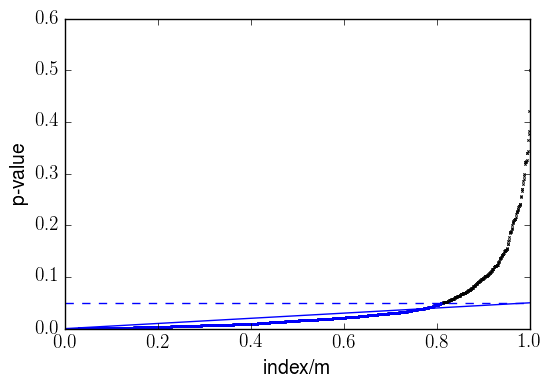

In [153]:
#check i/m vs. p-values
indexm = np.arange(1,len(pval_975)+1,1)
im = 1.0*indexm / len(pval_975)
thres = 0.05*im
pval_975_s = sorted(pval_975)
#pval_025_s = sorted(pval_025)
smaller=[]
small_index=[]
larger=[]
large_index=[]

n=0
for pp in pval_975_s:
#for pp in pval_025_s:
    if pp <=0.05:
        smaller.append(pp)
        small_index.append(im[n])
    else:
        larger.append(pp)
        large_index.append(im[n])
    n=n+1

plt.plot(im,pval_975_s,'kx',markersize=1.5)
#plt.plot(im,pval_025_s,'kx',markersize=1.5)
plt.plot(im,thres)
plt.plot(small_index,smaller,'bx',markersize=1.5)
plt.plot(large_index,larger,'kx',markersize=1.5)
plt.axhline(y=0.05,linestyle='dashed')
plt.xlabel('index/m',fontsize=14)
plt.ylabel('p-value',fontsize=14)
plt.tick_params(labelsize=14)

FDR procedure

In [154]:
#start FDR procedure
pvalr_975 = FloatVector(pval_975)
pvalr_025 = FloatVector(pval_025)
pvalr_med = FloatVector(pval_med)

r.source("fdr.R")
#sig_975 = r.fdr(pvalr_975,method="original",adjustment_method="mean")
#sig_025 = r.fdr(pvalr_025,method="original",adjustment_method="mean")
#sig_med = r.fdr(pvalr_med,method="original",adjustment_method="mean")

sig_975 = r.fdr(pvalr_975,method="original")
sig_025 = r.fdr(pvalr_025,method="original")
sig_med = r.fdr(pvalr_med,method="original")

#print(sig_975)
#prepare all global grids
latmedian=latt[:]
lonmedian=lont[:]
lat975=latt[:]
lon975=lont[:]
lat025=latt[:]
lon025=lont[:]

#delete grids which are significant
if sig_975:
    for isig in sorted(sig_975,reverse=True):
         del lat975[isig-1]
         del lon975[isig-1]
#        lat975.append(latt[isig-1])
#        lon975.append(lont[isig-1])

if sig_025:
    for isig in sorted(sig_025,reverse=True):
        del lat025[isig-1]
        del lon025[isig-1]

if sig_med:
    for isig in sorted(sig_med,reverse=True):
        del latmedian[isig-1]
        del lonmedian[isig-1]

Plot figures of distributions of correlations (median, IQR, 2.5% quantile, 97.5% qunatile)

In [180]:
#plot figures
map = Basemap(projection='robin',resolution='l',lat_0=0,lon_0=180)
#map.drawcoastlines()
#map.fillcontinents(color='gray')
#map.drawmapboundary()
#map.drawmeridians(np.arange(0,360,30))
#map.drawparallels(np.arange(-90,90,30))

lons, lats = np.meshgrid(lon0, lat0)
x,y=map(lons,lats)
fig=plt.figure(figsize=(10,8))
ax1=fig.add_subplot(221)
#map.drawcoastlines(linewidth=1)
map.fillcontinents(color='gray')
#map.drawmapboundary()
map.drawmeridians(np.arange(0,360,30),color='DimGray')
map.drawparallels(np.arange(-90,90,30),color='DimGray')
clevs=np.linspace(-1,1,21)
cs=map.contourf(x,y,corrQ_new[:,:,1],clevs,cmap=plt.cm.RdBu_r)
cbar = map.colorbar(cs,location='bottom')
cbar.ax.tick_params(labelsize=14)
x2,y2=map(lonmedian,latmedian)
passt=map.plot(x2,y2,'ko',markersize=1.5)
ax1.set_title("(a) median",fontsize=14)

ax2=fig.add_subplot(222)
#map.drawcoastlines(linewidth=1)
map.fillcontinents(color='gray')
#map.drawmapboundary()
map.drawmeridians(np.arange(0,360,30),color='DimGray')
map.drawparallels(np.arange(-90,90,30),color='DimGray')
#clevs=np.linspace(0.8,1.5,10)
cs=map.contourf(x,y,IQR,cmap=plt.cm.OrRd)
cbar = map.colorbar(cs,location='bottom')
cbar.ax.tick_params(labelsize=14)
ax2.set_title("(b) IQR",fontsize=14)

ax3=fig.add_subplot(223)
#map.drawcoastlines(linewidth=1)
map.fillcontinents(color='gray')
#map.drawmapboundary()
map.drawmeridians(np.arange(0,360,30),color='DimGray')
map.drawparallels(np.arange(-90,90,30),color='DimGray')
clevs=[-1,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0]
cs=map.contourf(x,y,corrQ_new[:,:,0],clevs,cmap=plt.cm.GnBu_r)
cbar = map.colorbar(cs,location='bottom')
cbar.ax.tick_params(labelsize=14)
x2,y2=map(lon025,lat025)
passt=map.plot(x2,y2,'ko',markersize=1.5)
ax3.set_title("(e) 2.5% quantile (FDR)",fontsize=14)

ax4=fig.add_subplot(224)
map = Basemap(projection='robin',resolution='l',lat_0=0,lon_0=180)
#map.drawcoastlines()
map.fillcontinents(color='gray')
#map.drawmapboundary()
map.drawmeridians(np.arange(0,360,30),color='DimGray')
map.drawparallels(np.arange(-90,90,30),color='DimGray')
clevs=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
cs=map.contourf(x,y,corrQ_new[:,:,2],clevs,cmap=plt.cm.OrRd)
cbar = map.colorbar(cs,location='bottom')
cbar.ax.tick_params(labelsize=14)
x2,y2=map(lon975,lat975)
passt=map.plot(x2,y2,'ko',markersize=1.5)
ax4.set_title("(f) 97.5% quantile (FDR)",fontsize=14)

Plot the spectra by using the MTM method

First load age model results

In [170]:
#d18O from McCabe paper
data_mc = genfromtxt('McCabe_crystal.txt', delimiter=',')
d18O_mc = data_mc[0:,2]
d18O_mc_rm = d18O_mc-np.mean(d18O_mc)

# load Bchron data
crys = np.load('Crystal_Bchron.npz')
chronCE = crys['chronCE']
depth = crys['depth_horizons']
chronQ  = mquantiles(chronCE, prob=[0.025, 0.5, 0.975], axis=1)


Calculate the spectra of the median $\delta^{18}O$ from Bchron results

In [171]:
def spline_interp(tu,Xu,tstart,tend):
    tck = interpolate.splrep(tu,Xu,s=1)
    xnew = range(tstart,tend,1)
    ynew = interpolate.splev(xnew,tck)
    ynew_rm = ynew-np.mean(ynew)
    return ynew_rm

#MTM spectrum for the median d18O from Bchron
tu_bchron, Xu_bchron = coarse_grain(chronQ[:,1],Xr)
ynew_bchron = spline_interp(tu_bchron,Xu_bchron,1000,2008)
f_m, psd_mt_m, nu_m = alg.multi_taper_psd(ynew_bchron, Fs=1.0, adaptive=False,jackknife=False)

#MTM spectrum for the d18O from McCabe paper
f_mc, psd_mt_mc, nu_mc = alg.multi_taper_psd(d18O_mc_rm,Fs=1.0,adaptive=False,jackknife=False)

#AR1 simulation (1000 ensembles)
pmtm_ar=np.zeros((len(f_m),chronCE.shape[1]))

#Bchron ensembles MTM spectrum
psd_multi=np.zeros((len(f_m),chronCE.shape[1]))

Calculate all possible spectras from Bchron results

In [172]:
for it in range(chronCE.shape[1]):

    tu, Xu = coarse_grain(chronCE[:,it],Xr)
    ynew_rm = spline_interp(tu,Xu,1000,2008)
    f, psd_mt, nu = alg.multi_taper_psd(ynew_rm,Fs=1.0,adaptive=False,jackknife=False)
    psd_multi[:,it]=psd_mt

    coef,sigma=alg.AR_est_YW(ynew_rm,1)
    X_ar, noise, aph = utils.ar_generator(len(ynew_rm), sigma, coef)
    f_ar, psd_mt_ar, nu_m = alg.multi_taper_psd(X_ar ,Fs=1.0,adaptive=False,jackknife=False)
    pmtm_ar[:,it]=psd_mt_ar

Plot the spectra

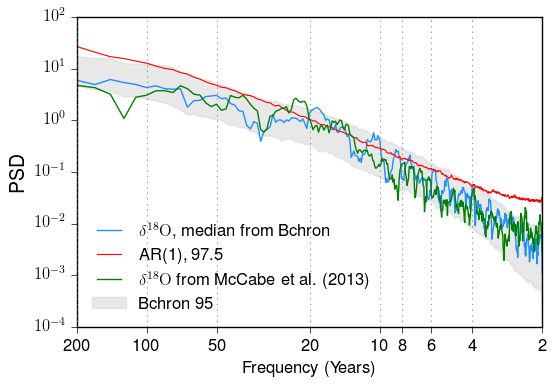

In [175]:
pq  = mquantiles(pmtm_ar, prob=[0.025, 0.5, 0.975], axis=1)
psdQ  = mquantiles(psd_multi, prob=[0.025, 0.5, 0.975], axis=1)

#plot the figure
pertick=np.array([200, 100 ,50, 20,10,8, 6,4, 2])
pertick_labels=(['200', '100' ,'50', '20','10','8' ,'6','4', '2'])

xtick=(1.0/pertick)

plt.loglog(f_m, psd_mt_m,label=r'$\delta^{18}\mathrm{O}$, median from Bchron', color='DodgerBlue',linewidth=1)
plt.loglog(f_ar, pq[:,2], label='AR(1), 97.5% quantile',color='red',linewidth=0.8)
plt.loglog(f_mc, psd_mt_mc,label=r'$\delta^{18}\mathrm{O}$ from McCabe et al. (2013)', color='green',linewidth=1)
plt.fill_between(f,psdQ[:,0],psdQ[:,2],label='Bchron 95% CI',facecolor='lightgrey',color='lightgrey',alpha=0.5)
plt.xlabel('Frequency (Years)',fontsize=12)
plt.ylabel('PSD',fontsize=14)

plt.xlim([1./200.,0.5])
plt.ylim([1e-4, 1e2])
plt.xticks(xtick, pertick_labels, size='small')
plt.tick_params(axis="both", which="both", bottom="on", top="off",
                labelbottom="on", left="on", right="off", labelleft="on",direction="out",labelsize=12)
plt.minorticks_off()
plt.grid('on',axis='x',color='DimGray')
plt.legend(loc=3,fontsize=12,frameon=False)